# MA934  Numerical Methods - Workbook 2

In [1]:
using Plots
pyplot()
include("KVPair.jl")
include("LList.jl")
include("FTree.jl")

buildFTree (generic function with 1 method)

## Question 1: Linear search using a linked list

The file KVPair.jl defines a simple data structure to represent an (Int64, Float64) key-value pair. 

The file LList.jl defines a linked list that stores a KVPair at each node. Many languages have a keyword NULL. A pointer to any object can take the value NULL to indicate that it doesn't point to anything. NULL is often used to denote the end of a list, the leaves of a tree etc. Julia does not support NULL pointers. This causes a difficulty in implementing recursive data structures. Instead Julia provides a parametric data type Nullable{T} to represent missing values. It is possible to use Nullable types to define recursive data structures although some of the resulting definitions are a bit clumsy. I'm not sure that this is the canonical way to implement structural recursion in Julia. 

The following points are important:

* if a variable has type Nullable{T} then it can either contain a value of type T or nothing (ie a missing value). 
* the function isnull(x) checks whether a nullable type x has a value or not. 
* the function get(x) returns the actual value (of type T) contained in a nullable type x.

Much more information can be found at https://docs.julialang.org/en/stable/manual/types/

The function 

> buildLList(dataArray::Array{KVPair, 1})

takes an array of KVPair objects as input and returns an LList containing these KVPairs. This is illustrated in the code below.

1. Write a recursive function that traverses the list and prints out the key-value pairs stored in it. Check that your function works.
2. Write a function search(list::Nullable{LList}, k::Int64) that searches an LList for the key k and returns the corresponding KVPair if it is present and a Nullable{KVPair} otherwise. Verify that your function works.
3. Use Julia's @timed macro to measure how the typical computational cost of your search() function grows with the length of the list. 

In [2]:
n=10
seed = 407
# Initialise the random number generator
rng = MersenneTwister(seed)
X = rand(rng, n)

# Now calculate the array of partial sums
values = Array{KVPair}(n)

for i in 1:n
    values[i] = KVPair(i,X[i])
end

L = Nullable{LList}()
L = buildLList(values)

print("Values stored inside linked list\n \n")

while isnull(L)==false
    println(get(L).data.value)
    L = get(L).next
end

print("\nInitial values\n\n")
for i in 1:n
    println(X[i])
end

Values stored inside linked list
 
0.43961861950855785
0.2626291517677901
0.20302303526281618
0.6744176910355224
0.6681680672585995
0.6373493817158131
0.6647363485694235
0.20651522488304153
0.28905555776886604
0.30684514931446927

Initial values

0.43961861950855785
0.2626291517677901
0.20302303526281618
0.6744176910355224
0.6681680672585995
0.6373493817158131
0.6647363485694235
0.20651522488304153
0.28905555776886604
0.30684514931446927


In [3]:
include("search.jl")
n=10

seed = 407

rng = MersenneTwister(seed)

X = rand(rng, n)

# Now calculate the array of partial sums
values = Array{KVPair}(n)

for i in 1:n
    values[i] = KVPair(i,X[i])
end

L = Nullable{LList}()
L = buildLList(values)

Nullable{LList}(LList(KVPair(1,0.439619),LList(KVPair(2,0.262629),LList(KVPair(3,0.203023),LList(KVPair(4,0.674418),LList(KVPair(5,0.668168),LList(KVPair(6,0.637349),LList(KVPair(7,0.664736),LList(KVPair(8,0.206515),LList(KVPair(9,0.289056),LList(KVPair(10,0.306845),#NULL)))))))))))


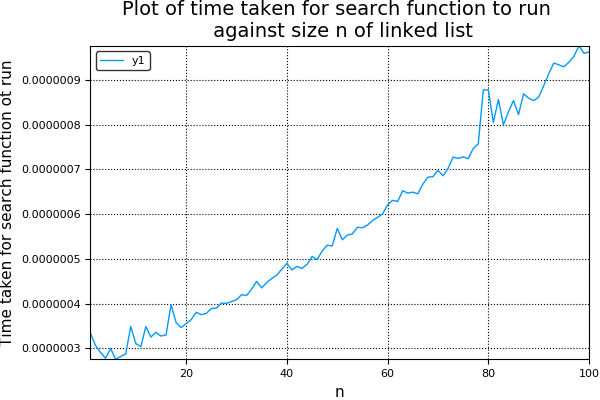

In [6]:
l=100
m=1000
t = zeros(l,m)

for i=1:l
    
        for k=1:m
            randnum = rand(1:i)
            n = i
            X = rand(rng, n)
            values = Array{KVPair}(n)
            for j in 1:n
                values[j] = KVPair(j,X[j])
            end

            L = Nullable{LList}()
            L = buildLList(values)
            ~,t[i,k],~,~,~=@timed(search(L, Int64(randnum)))
        end
end
    
tfinal = mean(t,2)
indi = 1:l
plot(indi, tfinal)
xlabel!("n")
ylabel!("Time taken for search function ot run")
title!("Plot of time taken for search function to run \n against size n of linked list")


## Question 2: Interval membership

The problem of interval membership is the following: given a set of contiguous intervals, 

$\left\{[x_0, x_1), [x_1, x_2), \ldots, [x_{n-2}, x_{n-1}), [x_{n-1}, x_n)\right\}$

spanning the interval $[x_1, x_n)$ and given a random number $x \in [x_1, x_n)$, determine the interval in which $x$ lies. The standard numerical algorithm for stochastic simulation of continuous-time Markov processes (eg birth-death process, contact process, SIR model etc) requires solving an interval membership problem at each time step. It is therefore important to be able to solve it efficiently. Note, we cannot assume that all intervals are the same length.

We can solve the interval membership problem with $n$ interval by a variant of linear search in $O(n)$ time. We will demonstrate below that it can be solved in $O(\log\, n)$ time using a variant of a data structure known as a Fenwick tree.

**1)** Use Julia's random number generator to generate $n$ random interval lengths, $y_1, y_2, \ldots, y_n$ between 0 and 1 as shown: 

In [7]:
# Set number of intervals
n=10
# Seed for random number generator. 
# You should choose your own seed so that everyone does not end up with the same random sequences
seed = 407
# Initialise the random number generator
rng = MersenneTwister(seed)
# Generate a sample of n uniform random numbers in the interval [0,1]
y = rand(rng, n);
x = cumsum(y)

10-element Array{Float64,1}:
 0.439619
 0.702248
 0.905271
 1.57969 
 2.24786 
 2.88521 
 3.54994 
 3.75646 
 4.04551 
 4.35236 

The corresponding interval membership problem is constructed from the partial sums:
$$x_i = \sum_{j=1}^i y_j, \ \ \ \ \ i=1,2,\ldots n.$$ 
Using the objects defined in KVPair.jl and LList.jl, create an array of key-value pairs, $(i, x_i)$, associating each interval with the corresponding partial sum and store this array in a linked list. Print the list for a small value of $n$to verify that it works.

**2)** Modify the search function you wrote above to write a recursive function

$$\text{intervalmembership(list::Nullable{LList}, x::Float64)}$$

that takes the LList containing the list of partial sums and a random Float64 in the range $[0, x_n]$ as inputs and returns the KVPair corresponding to the interval in which $x$ lies. Verify that it works for small values of $n$ and use Julia's @timed macro to measure how the typical computational cost grows with $n$. 

**3)** The file FTree.jl defines a data structure implementing a variant of a Fenwick tree that can solve the interval membership problem as described in the lectures/notes. The function 

$$\text{buildFTree(T::Nullable{FTree}, dataArray::Array{KVPair, 1})}$$

takes the array of KVPairs containing the interval lengths as input, recursively constructs the tree and returns the FTree containing the correct key-value pairs (note a key of -1 is assigned to all non-leaf nodes).

In [5]:
n=10

seed = 407

rng = MersenneTwister(seed)

y = rand(rng, n);
x = cumsum(y)

q2values = Array{KVPair}(n)

for i in 1:n
    q2values[i] = KVPair(i,x[i])
end

q2L = Nullable{LList}()
q2L = buildLList(q2values)

while isnull(q2L)==false
    println(get(q2L).data.value)
    q2L = get(q2L).next
end

0.43961861950855785
0.702247771276348
0.9052708065391641
1.5796884975746865
2.247856564833286
2.885205946549099
3.5499422951185227
3.756457520001564
4.04551307777043
4.352358227084899


In [11]:
include("q2search.jl")
q2L = Nullable{LList}()
q2L = buildLList(q2values)
q2search(q2L, Float64(3.3546))

KVPair(7,3.5499422951185227)

In [6]:
n=5
X = rand(rng, 5)
# Now calculate the array of partial sums
values = Array{KVPair}(5)
for i in 1:n
    values[i] = KVPair(i,X[i])
end
T = Nullable{FTree}(FTree(KVPair(0,0.0)))
T = buildFTree(T, values);

Write a recursive function

$$\text{intervalmembership(FT::Nullable{FTree}, x::Float64)}$$

that takes the FTree containing the list of partial sums and a random Float64 in the range $[0, x_n]$ as 
inputs and returns the KVPair corresponding to the interval in which $x$ lies. Verify that it works for small values of $n$ and use Julia's @timed macro to compare how the typical computational compares to the above linear search version. Note it can sometimes be difficult to directly measure $O(\log\, n)$ growth in computation time since the problem size needs to become very large to register appreciable run times.

In [8]:
n=5
rng = MersenneTwister(seed)
X = rand(rng, 5)
# Now calculate the array of partial sums
values2 = Array{KVPair}(5)
for i in 1:n
    values2[i] = KVPair(i,X[i])
end
T = Nullable{FTree}(FTree(KVPair(0,0.0)))
T=buildFTree(T, values2);
typeof(T)
include("FenSearch.jl")
#println(FenSearch(T, 1.23973))
println(FenSearch(T, 1.23973).key)
println(values2)

4
KVPair[KVPair(1,0.439619),KVPair(2,0.262629),KVPair(3,0.203023),KVPair(4,0.674418),KVPair(5,0.668168)]



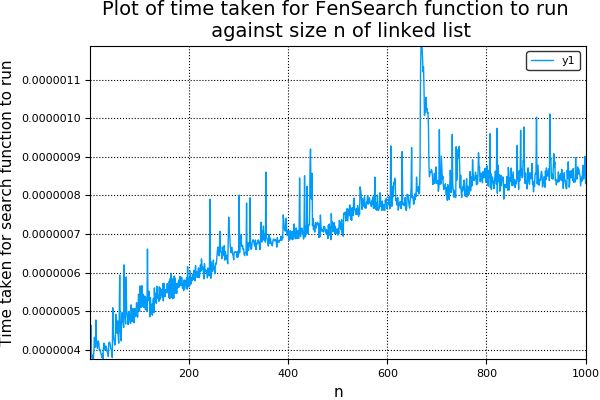

In [17]:
l=1000
m=100
t = zeros(l,m)

for i=1:l
    
        for k=1:m
            n=i
            X = rand(rng, n)
            values2 = Array{KVPair}(n)
            for j in 1:n
                values2[j] = KVPair(j,X[j])
            end
            max = sum(X)
            randnum = X*rand()
            T = Nullable{FTree}(FTree(KVPair(0,0.0)))
            T = buildFTree(T, values2);
            ~,t[i,k],~,~,~=@timed(FenSearch(T, Float64(randnum[1])))
        end
end
    
tfinal = mean(t,2)
indi = 1:l
plot(indi, tfinal)
xlabel!("n")
ylabel!("Time taken for search function to run")
title!("Plot of time taken for FenSearch function to run \n against size n of linked list")


## Question 3: Gillespie algorithm for heterogeneous diffusion

The Gillespie algorithm is a dynamic Monte Carlo algorithm that generates statistically correct realisations of a continous time Markov process. See https://en.wikipedia.org/wiki/Gillespie_algorithm It is used heavily in stochastic simulation of chemical and biological reaction networks and population dynamics. In this question we use it to simulate one-dimensional diffusion of heterogeneous particles whose diffusion constants are independently drawn from an exponential distribution.

The basic idea of the algorithm is as follows
1. Create a list $\left\{(i, r_i), i=1,\ldots M\right\}$,  of all possible transitions (events), $i$, that can occur in the system and the corresponding transition rates, $r_i$.
2. Calculate the total rate
$$R = \sum_{i=1}^M r_i$$
and divide the interval $[0, R]$ into $M$ intervals whose lengths are given by the $r_i$.
3. Generate a uniform random number in the range $[0,R]$ and determine which interval it falls in. 
4. Perform the corresponding transition and update the time variable by an amount $\Delta t = 1/R$.
5. Repeat until the desired simulation time is reached.

To be concrete, suppose with have $N$ particles on the interval $[-L, L]$ initially located at $x=0$. Each particle can hop a distance $\Delta x$ to the left or to the right with equal probability. The rate of hopping is initially considered to be the same for all particles:

$$ r_i = \frac{D}{2}\,\frac{1}{(\Delta x)^2} $$

This choice ensures that in the continous limit ($\Delta x \to 0$, $N\to \infty$), the density of particles $c(x,t)$ on the line will satisfy the usual diffusion equation with diffusion coefficient $D$ (recall MA933):

$$ \frac{\partial c}{\partial t} = D \frac{\partial^2 c}{\partial x^2}$$

with initial condition $c(x,0) = \delta(x)$.

The steps of the algorithm then correspond to the following:
1. There are $M= 2 N$ possible transitions at each step: each of $N$ particles can hop a distance $\Delta x$ either left or right with the above rates. We index them as follows: events k=1:N correspond to particle k hopping to the right, events k=N+1:2N correspond to particle k-N hopping to the left.
2. The total rate is 
$$ R = \frac{D N}{(\Delta x)^2}.$$
3. Generate a uniform random number in the range $[0,R]$ and determine the index $k$ of particle to move and the direction.
4. Update the position of particle $k$ accordingly.
5. Repeat.

The following piece of code implements the Gillespie algorithm for N=100, L=10, $\Delta x = 0.1$ and $D=1$, converts the particle positions to particle density and compares to the solution of the diffusion equation on an unbounded domain at t=1 (we assume that L=10 is far enough from zero to be considered unbounded):

$$c(x, t) = \frac{1}{\sqrt{2 \pi D t}}\, \exp [-\frac{1}{2}\frac{x^2}{D t} ]$$


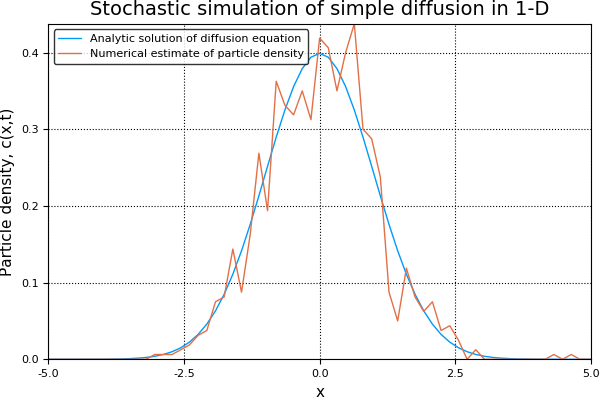

In [23]:
include("GillespieConst.jl")
include("normal.jl")

P, P1, X = GillespieConst(40, 1000, 1)

plot(X, P1, label="Analytic solution of diffusion equation",xlims=(-5,5))
plot!(X, P, label="Numerical estimate of particle density")
xlabel!("x")
ylabel!("Particle density, c(x,t)")
title!("Stochastic simulation of simple diffusion in 1-D")
    

**1)** The code above makes critical use of the fact that all intervals have the same width in order to decide which particle to move at each step. Suppose now that instead of being equal to $D$ for each particle, the diffusion coefficients are drawn from an exponential distribution with mean $D$:

$$ P(x) = \frac{1}{D} \exp\left(-\frac{x}{D}\right). $$

Modify the code to account for this, using your code from Q2 above to solve the interval membership problem using linear search. You will need to use Julia's randexp() function to generate values for the diffusion coefficients. What is the largest value of $N$ you can simulate in a "reasonable" time?

**2)** Try again using your Fenwick tree from Q2 to solve the interval membership problem and compare. What is the largest value of $N$ you can simulate now?

**3)** Show analytically that the solution of the heterogenous diffusion problem is

$$ c(x,t) = \frac{\exp \left(-\sqrt{\frac{2}{D\,t}}\, |x| \right)}{\sqrt{2\, D\, t}}$$

You will probably need the integral formula (Formula 3.325 of Gradshteyn and Rizhik, 7th Ed.)

$$ \int_0^\infty \exp\left(-a\,x^2 - \frac{b}{x^2} \right)\, dx =  \frac{1}{2}\,\sqrt{\frac{\pi}{a}}\,\exp\left(-2 \sqrt{a\,b} \right).$$
Use this formula to validate your numerical results.




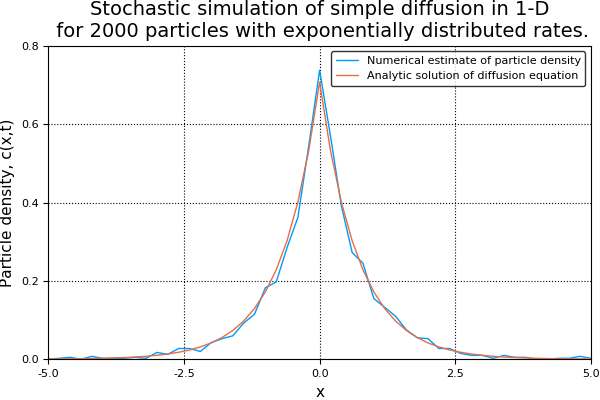

In [37]:
#####USING LINKED LISTS#######
using Distributions
include("GillespieLL.jl")
include("analysol.jl")
PL, P2, XL = GillespieLL(20, 2000, 1)
plot(XL, PL, label="Numerical estimate of particle density", xlims=(-5,5), ylims=(0,0.8))
plot!(XL, P2, label="Analytic solution of diffusion equation", xlims=(-5,5), ylims=(0,0.8))
title!("Stochastic simulation of simple diffusion in 1-D\n for 2000 particles with exponentially distributed rates.")
xlabel!("x")
ylabel!("Particle density, c(x,t)")


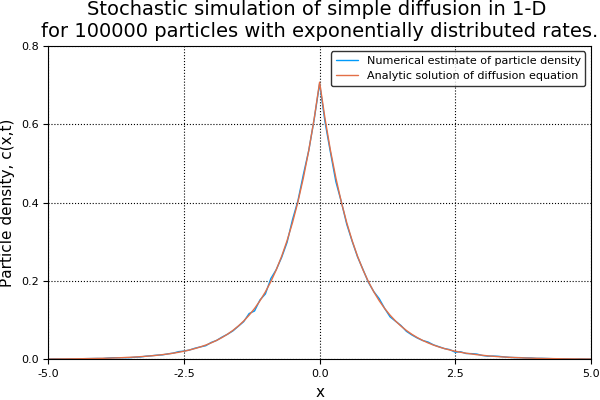

In [36]:
#####USING FENWICK TREES######
using Distributions
include("GillespieFT.jl")
include("analysol.jl")
PT, PanT, XT = GillespieFT(10, 100000, 1)
plot(XT, PT, label="Numerical estimate of particle density", xlims=(-5,5), ylims=(0,0.8))
plot!(XT, PanT, label="Analytic solution of diffusion equation", xlims=(-5,5), ylims=(0,0.8))
title!("Stochastic simulation of simple diffusion in 1-D \nfor 100000 particles with exponentially distributed rates.")
xlabel!("x")
ylabel!("Particle density, c(x,t)")

The solution the this heterogeneous diffusion problem will be given by the average of the solutions for each particle. So 
\begin{equation}
c(x,t) = \int_0^{\infty} \frac{1}{D}e^{-\frac{y}{D}}\frac{1}{\sqrt{2\pi yt}}e^{-\frac{x^2}{2yt}} \, dy.
\end{equation}Letting $y=u^2$, we can write this as the following integral: 
\begin{equation}
\frac{1}{D}\frac{1}{\sqrt{2\pi t}}\int_0^{\infty} \frac{1}{u}e^{-\frac{u^2}{D}-\frac{x^2}{2t}\frac{1}{u^2}}2u \, du.
\end{equation}
Using the result given above with $a=\frac{1}{D}$, and $b=\frac{x^2}{2t}$, we get the following solution:
\begin{equation}
c(x,t) = \frac{2}{D\sqrt{2\pi t}} \frac{1}{2}\sqrt{D\pi}e^{-2\sqrt{\frac{x^2}{2Dt}}} = \frac{1}{\sqrt{2DT}}e^{-\sqrt{\frac{2}{DT}}|x|}
\end{equation}which is the desired result.

I now want to find the largest N I can simulate in a reasonable time using a linked list. For the purposes of this, I will assume a 'reasonable time' is 30 seconds. I will increase my value of N in multiples of 1000.

In [33]:
####Note to Colm: This will take a few minutes to finish running
include("GillespieLL.jl")
include("q2search.jl")
t=0
maxt = 30
k=1
oldtime = 0
newtime = 0

while newtime < maxt
    oldtime = newtime
    ~,newtime,~,~,~=@timed(GillespieLL(40, 1000*k, 1))
    k = k+1
end

println("The largest value of N (to nearest power of 10) for which it will run in 'reasonable time' is 1000*",k-2)
println(oldtime)

The largest value of N (to nearest power of 10) for which it will run in 'reasonable time' is 1000*11
28.259516683


I now want to find the largest N I can simulate in a reasonable time using Fenwick trees. For the purposes of this, I will assume a 'reasonable time' is 30 seconds. I will increase my value of N in powers of 10.

In [23]:
####Note to Colm: For this to finish running takes about 7-8 minutes as it has to finish timing the value of N
####after the one that can be run in a reasonable time.
t=0
maxt = 30
k=0
oldtime = 0
newtime = 0

while newtime < maxt
    oldtime = newtime
    ~,newtime,~,~,~=@timed(GillespieFT(40, 10^k, 1))
    k = k+1
end

println("The largest value of N (to nearest power of 10) for which it will run in 'reasonable time' is 10^",k-2)
println(oldtime)

The largest value of N (to nearest power of 10) for which it will run in 'reasonable time' is 10^6
20.722554344
